 le code complet et corrigé pour éviter une sensibilité de 0, en incluant l'équilibrage des classes et un modèle CNN-LSTM optimisé

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 49.8 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.5031 - loss: 0.6952 - val_accuracy: 0.5028 - val_loss: 0.6926
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.5141 - loss: 0.6932 - val_accuracy: 0.6289 - val_loss: 0.6927
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.4884 - loss: 0.6933 - val_accuracy: 0.5918 - val_loss: 0.6923
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.5068 - loss: 0.6929 - val_accuracy: 0.5510 - val_loss: 0.6919
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.5390 - loss: 0.6923 - val_accuracy: 0.5028 - val_loss: 0.6906
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.5229 - loss: 0.6906 - val_accuracy: 0.5232 - val_loss: 0.6890
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step - accuracy: 0.5482 - loss: 0.6892 - val_accuracy: 0.5714 - val_loss: 0.6855
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.5520 - loss: 0.6889 - val_accurac

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Évaluation finale :
Précision du test: 0.4972170686456401
Recall (moyenne pondérée): 0.4972170686456401
Précision (moyenne pondérée): 0.24722481335256313
Score F1 (moyenne pondérée): 0.3302457853705862
Sensibilité: 1.0
Spécificité: 0.0
Matrice de confusion:
 [[  0 271]
 [  0 268]]
Durée de l'entraînement (secondes): 272.17096638679504


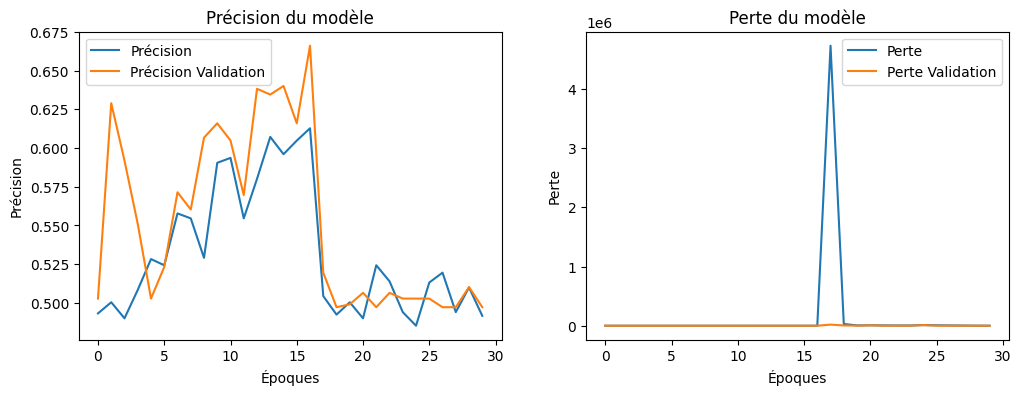

In [3]:
import numpy as np
import pywt
import time
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

def wavelet_decompose(data, wavelet='db4', level=5):
    processed_data = []
    for sample in data:
        coeffs = pywt.wavedec(sample.flatten(), wavelet, level=level)
        processed_sample = np.concatenate(coeffs)
        processed_data.append(processed_sample)
    return np.array(processed_data)

def load_data(num_samples=1000, num_features=256):
    np.random.seed(42)
    data = np.random.rand(num_samples, num_features)
    labels = np.random.choice([0, 1], size=num_samples, p=[0.9, 0.1])
    return data, labels

data_all, labels_all = load_data()
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
data_all, labels_all = ros.fit_resample(data_all, labels_all)
data_all = wavelet_decompose(data_all)
labels_all_one_hot = to_categorical(labels_all, num_classes=2)

X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all_one_hot, test_size=0.3, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(128, activation='relu', return_sequences=False),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
training_duration = time.time() - start_time

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1]) if (conf_matrix[1, 0] + conf_matrix[1, 1]) > 0 else 0
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1]) if (conf_matrix[0, 0] + conf_matrix[0, 1]) > 0 else 0

print("\nÉvaluation finale :")
print("Précision du test:", accuracy)
print("Recall (moyenne pondérée):", recall)
print("Précision (moyenne pondérée):", precision)
print("Score F1 (moyenne pondérée):", f1)
print("Sensibilité:", sensitivity)
print("Spécificité:", specificity)
print("Matrice de confusion:\n", conf_matrix)
print("Durée de l'entraînement (secondes):", training_duration)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Précision')
plt.plot(history.history['val_accuracy'], label='Précision Validation')
plt.title('Précision du modèle')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perte')
plt.plot(history.history['val_loss'], label='Perte Validation')
plt.title('Perte du modèle')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.show()
